In [1]:
import torch 
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sea
from tqdm.notebook import tqdm

In [3]:
import sys
sys.path.append("/home/autrio/college-linx/SMAI/smai-m24-assignments-Autrio/")


In [4]:
!export PYTHONWRITEBYTECODE=1

In [5]:
from models.CNN.data import Loader
import models.CNN.cnn as cnn
from models.CNN.metrics import Metrics

In [6]:
import os

#! Set the environment variables to override gpu (specically for my device)
os.environ['HSA_OVERRIDE_GFX_VERSION'] = '10.3.0'
os.environ['ROCBLAS_TENSILE_LIBRARY'] = '/home/autrio/.local/lib/python3.10/site-packages/torch/lib/rocblas/library/TensileLibrary_lazy_gfx1030.dat'



In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
plt.style.use('seaborn')
np.__version__, device

/tmp/ipykernel_1572831/2995231395.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


('1.26.4', 'cuda')

In [8]:
class logger:
    def __init__(self):
        self.history = []

    def log(self,x):
        self.history.append(x)

    def finish(self):
        return

# Q2 Classification and Regression With CNN

### Q2.1 Data Loading and Preprocessing

In [9]:
params = {
    'lr' : 0.001,
    'batch_size': 32,
    'epoch': 20, 
    'use_dropout': True,
    'kernel_size': 3,
    'padding': 1,
    'task' : 'single'
}

The `data.py` file contains the implementation of the `MultiMNISTdataset` class 

The `Loader` function makes the dataloaders for pytorch. It extracts images from the
dataset folders and organizes them into separate lists for images and labels
corresponding to the train, validation, and test splits.

In [10]:
path = "/home/autrio/college-linx/SMAI/smai-m24-assignments-Autrio/data/external/double_mnist"
train_L,test_L,val_L = Loader(path,task=params['task'],batch_size = params['batch_size'])

single_batch = next(iter(train_L))
inputs, labels = single_batch

sample_tensor = inputs[0]
print(sample_tensor.shape)

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/710 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

Data Split into (4600, 2) test samples, (12600, 2) training samples and (3000, 2) Validation samples


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/710 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

Data Split into (4600, 2) test samples, (12600, 2) training samples and (3000, 2) Validation samples


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/710 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

Data Split into (4600, 2) test samples, (12600, 2) training samples and (3000, 2) Validation samples
torch.Size([1, 32, 32])


The dataset contains an image file path and a label associated with the image

The dataloader processes the image in the filepath from the dataset and makes a set of $1\times 28\times 28$ tensor that corresponds to the grayscale image of the digit

overall the shape of the train dataset for instance is $60000\times 1\times 28\times 28$

### Q2.2 a. CNN Runtime - Classification

In [11]:

net = cnn.net(params)

The model architecture is deifned in the following function call

`net.Convlayer()` coresponds to a sequential **convnet** that is a 2D convolution layer with stride 1 (kernel size and padding defined in parameters) followed by ReLU activation function and a 2x2 maxPool layer

`net.drop()` initiates a dropout of 0.2 whenever and wherever called

In [12]:
def single_class_net(usr_net):
    usr_net.add(usr_net.Convlayer(1,32))
    usr_net.add(usr_net.Convlayer(32,64))
    usr_net.add(usr_net.drop())
    usr_net.add(usr_net.Convlayer(64,128))
    usr_net.add(nn.Flatten())
    usr_net.add(usr_net.drop())
    usr_net.add(nn.Linear(128*4*4,128*1*1))
    usr_net.add(nn.Linear(128,64))
    usr_net.add(nn.Linear(64,32))
    usr_net.add(nn.Linear(32,3))
    usr_net.add(nn.Softmax(dim=1))

single_class_net(net)

In [13]:
logger1 = logger()

In [14]:
metrics = Metrics(task=params['task'])

model = cnn.Model(model=net)
model.set_attr(loss_fn=metrics.loss_fn(),train_loader=train_L,val_loader=val_L,
               device=device,params=params,metrics=metrics,logger=logger1)

In [15]:
model.train()

Training:   0%|          | 0/20 [00:00<?, ?epoch/s]

  0%|          | 0/144 [00:00<?, ?it/s]

/home/autrio/.local/lib/python3.10/site-packages/torch/nn/modules/linear.py:125: UserWarning: Attempting to use hipBLASLt on an unsupported architecture! Overriding blas backend to hipblas (Triggered internally at ../aten/src/ATen/Context.cpp:296.)
  return F.linear(input, self.weight, self.bias)


  0%|          | 0/394 [00:00<?, ?it/s]

[Epoch: 0] Train:[loss:0.922 acc:0.593] Val:[loss:0.871 acc:0.662]


  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/394 [00:00<?, ?it/s]

[Epoch: 1] Train:[loss:0.833 acc:0.716] Val:[loss:0.762 acc:0.727]


  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/394 [00:00<?, ?it/s]

[Epoch: 2] Train:[loss:0.723 acc:0.769] Val:[loss:0.801 acc:0.739]


  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/394 [00:00<?, ?it/s]

[Epoch: 3] Train:[loss:0.742 acc:0.738] Val:[loss:0.813 acc:0.726]


  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/394 [00:00<?, ?it/s]

[Epoch: 4] Train:[loss:0.666 acc:0.767] Val:[loss:0.812 acc:0.727]


  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/394 [00:00<?, ?it/s]

[Epoch: 5] Train:[loss:0.730 acc:0.777] Val:[loss:0.752 acc:0.739]


  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/394 [00:00<?, ?it/s]

[Epoch: 6] Train:[loss:0.762 acc:0.780] Val:[loss:0.798 acc:0.741]


  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/394 [00:00<?, ?it/s]

[Epoch: 7] Train:[loss:0.767 acc:0.776] Val:[loss:0.826 acc:0.712]


  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/394 [00:00<?, ?it/s]

[Epoch: 8] Train:[loss:0.764 acc:0.775] Val:[loss:0.798 acc:0.742]


  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/394 [00:00<?, ?it/s]

[Epoch: 9] Train:[loss:0.758 acc:0.780] Val:[loss:0.796 acc:0.744]


  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/394 [00:00<?, ?it/s]

[Epoch: 10] Train:[loss:0.770 acc:0.770] Val:[loss:0.805 acc:0.734]
Early stopping triggered after 11 epochs || best model accuracy : 0.7435490693739424


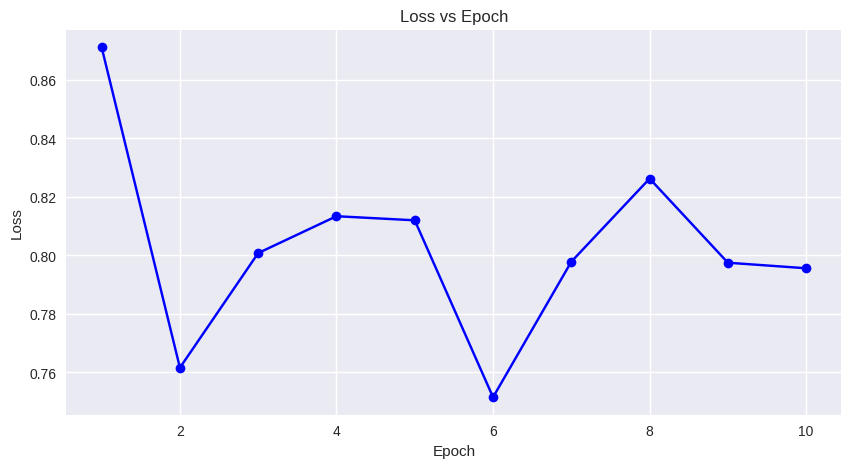

In [16]:
his = logger1.history
loss = [h["val_loss"] for h in his]
epochs = list(range(1, len(loss) + 1))

plt.figure(figsize=(10, 5))
plt.plot(epochs, loss, marker='o', linestyle='-', color='b')
plt.title("Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [17]:
performance = pd.DataFrame([model.eval(test_L)])
performance

  0%|          | 0/94 [00:00<?, ?it/s]

,loss,accuracy,hamming loss,f1 score
0,0.811212,0.727726,0.270333,0.595869


### Q2.2 b. CNN Runtime - Regression


In [18]:
params = {
    'lr' : 1e-4,
    'batch_size': 256,
    'epoch': 60, 
    'use_dropout': True,
    'kernel_size': 3,
    'padding': 1,
    'task' : 'regression'
}

In [19]:
path = "/home/autrio/college-linx/SMAI/smai-m24-assignments-Autrio/data/external/double_mnist"
train_L,test_L,val_L = Loader(path,task=params['task'],batch_size = params['batch_size'])

single_batch = next(iter(train_L))
inputs, labels = single_batch

sample_tensor = inputs[0]
print(sample_tensor.shape)

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/710 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

Data Split into (4600, 2) test samples, (12600, 2) training samples and (3000, 2) Validation samples


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/710 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

Data Split into (4600, 2) test samples, (12600, 2) training samples and (3000, 2) Validation samples


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/710 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

Data Split into (4600, 2) test samples, (12600, 2) training samples and (3000, 2) Validation samples
torch.Size([1, 32, 32])


In [20]:
net = cnn.net(params)

In [21]:
def regression_net(usr_net):
    usr_net.add(usr_net.Convlayer(1,32))
    usr_net.add(usr_net.Convlayer(32,64))
    usr_net.add(usr_net.drop())
    usr_net.add(usr_net.Convlayer(64,128))
    usr_net.add(nn.Flatten())
    usr_net.add(usr_net.drop())
    usr_net.add(nn.Linear(128*4*4,128*1*1))
    usr_net.add(nn.Linear(128,64))
    usr_net.add(nn.Linear(64,32))
    usr_net.add(nn.Linear(32,1))

regression_net(net)

Note that the classification model has an output size of 3 since it must classify between lengths 1,2,3. This aso includes a Softmax actication layer at the end of the model

Regression on the other hand has an output shape of 1 and no final activation layer

In [22]:
metrics = Metrics(task=params['task'])
logger2 = logger()
model = cnn.Model(model=net)
model.set_attr(loss_fn=metrics.loss_fn(),train_loader=train_L,val_loader=val_L,
               device=device,params=params,metrics=metrics,logger=logger2)

In [23]:
model.train()

Training:   0%|          | 0/60 [00:00<?, ?epoch/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 0] Train:[loss:3.068 acc:-4.607] Val:[loss:2.333 acc:-14.522]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 1] Train:[loss:0.884 acc:-0.608] Val:[loss:0.342 acc:-0.215]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 2] Train:[loss:0.411 acc:0.247] Val:[loss:0.319 acc:-0.249]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 3] Train:[loss:0.359 acc:0.341] Val:[loss:0.308 acc:-0.287]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 4] Train:[loss:0.315 acc:0.423] Val:[loss:0.254 acc:-0.037]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 5] Train:[loss:0.276 acc:0.494] Val:[loss:0.222 acc:0.020]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 6] Train:[loss:0.237 acc:0.567] Val:[loss:0.190 acc:0.077]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 7] Train:[loss:0.204 acc:0.626] Val:[loss:0.172 acc:0.089]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 8] Train:[loss:0.181 acc:0.667] Val:[loss:0.156 acc:0.125]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 9] Train:[loss:0.165 acc:0.697] Val:[loss:0.149 acc:0.115]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 10] Train:[loss:0.151 acc:0.724] Val:[loss:0.148 acc:0.098]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 11] Train:[loss:0.142 acc:0.741] Val:[loss:0.138 acc:0.143]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 12] Train:[loss:0.132 acc:0.757] Val:[loss:0.126 acc:0.195]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 13] Train:[loss:0.125 acc:0.772] Val:[loss:0.120 acc:0.205]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 14] Train:[loss:0.118 acc:0.784] Val:[loss:0.118 acc:0.209]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 15] Train:[loss:0.113 acc:0.792] Val:[loss:0.115 acc:0.219]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 16] Train:[loss:0.109 acc:0.799] Val:[loss:0.110 acc:0.252]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 17] Train:[loss:0.104 acc:0.809] Val:[loss:0.106 acc:0.268]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 18] Train:[loss:0.100 acc:0.816] Val:[loss:0.103 acc:0.283]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 19] Train:[loss:0.098 acc:0.820] Val:[loss:0.104 acc:0.268]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 20] Train:[loss:0.094 acc:0.827] Val:[loss:0.100 acc:0.285]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 21] Train:[loss:0.088 acc:0.838] Val:[loss:0.096 acc:0.317]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 22] Train:[loss:0.085 acc:0.843] Val:[loss:0.096 acc:0.307]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 23] Train:[loss:0.081 acc:0.852] Val:[loss:0.081 acc:0.429]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 24] Train:[loss:0.075 acc:0.861] Val:[loss:0.081 acc:0.428]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 25] Train:[loss:0.072 acc:0.869] Val:[loss:0.074 acc:0.466]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 26] Train:[loss:0.068 acc:0.875] Val:[loss:0.076 acc:0.452]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 27] Train:[loss:0.064 acc:0.883] Val:[loss:0.073 acc:0.473]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 28] Train:[loss:0.061 acc:0.889] Val:[loss:0.066 acc:0.514]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 29] Train:[loss:0.060 acc:0.891] Val:[loss:0.064 acc:0.528]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 30] Train:[loss:0.057 acc:0.895] Val:[loss:0.063 acc:0.542]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 31] Train:[loss:0.054 acc:0.900] Val:[loss:0.061 acc:0.558]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 32] Train:[loss:0.054 acc:0.902] Val:[loss:0.061 acc:0.560]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 33] Train:[loss:0.051 acc:0.906] Val:[loss:0.059 acc:0.582]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 34] Train:[loss:0.052 acc:0.905] Val:[loss:0.060 acc:0.567]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 35] Train:[loss:0.049 acc:0.910] Val:[loss:0.058 acc:0.571]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 36] Train:[loss:0.048 acc:0.911] Val:[loss:0.057 acc:0.602]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 37] Train:[loss:0.048 acc:0.911] Val:[loss:0.057 acc:0.584]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 38] Train:[loss:0.048 acc:0.913] Val:[loss:0.055 acc:0.604]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 39] Train:[loss:0.046 acc:0.915] Val:[loss:0.056 acc:0.599]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 40] Train:[loss:0.046 acc:0.916] Val:[loss:0.057 acc:0.597]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 41] Train:[loss:0.046 acc:0.915] Val:[loss:0.061 acc:0.560]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 42] Train:[loss:0.046 acc:0.916] Val:[loss:0.054 acc:0.631]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 43] Train:[loss:0.045 acc:0.917] Val:[loss:0.055 acc:0.602]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 44] Train:[loss:0.045 acc:0.918] Val:[loss:0.054 acc:0.610]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 45] Train:[loss:0.043 acc:0.921] Val:[loss:0.056 acc:0.606]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 46] Train:[loss:0.044 acc:0.920] Val:[loss:0.054 acc:0.616]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 47] Train:[loss:0.043 acc:0.922] Val:[loss:0.053 acc:0.629]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 48] Train:[loss:0.042 acc:0.922] Val:[loss:0.058 acc:0.578]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 49] Train:[loss:0.043 acc:0.922] Val:[loss:0.054 acc:0.620]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 50] Train:[loss:0.042 acc:0.923] Val:[loss:0.053 acc:0.631]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 51] Train:[loss:0.043 acc:0.922] Val:[loss:0.062 acc:0.555]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 52] Train:[loss:0.043 acc:0.921] Val:[loss:0.055 acc:0.621]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 53] Train:[loss:0.042 acc:0.923] Val:[loss:0.052 acc:0.642]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 54] Train:[loss:0.041 acc:0.925] Val:[loss:0.053 acc:0.625]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 55] Train:[loss:0.042 acc:0.924] Val:[loss:0.051 acc:0.643]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 56] Train:[loss:0.041 acc:0.925] Val:[loss:0.052 acc:0.632]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 57] Train:[loss:0.040 acc:0.927] Val:[loss:0.052 acc:0.631]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 58] Train:[loss:0.040 acc:0.926] Val:[loss:0.052 acc:0.640]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 59] Train:[loss:0.039 acc:0.928] Val:[loss:0.051 acc:0.649]


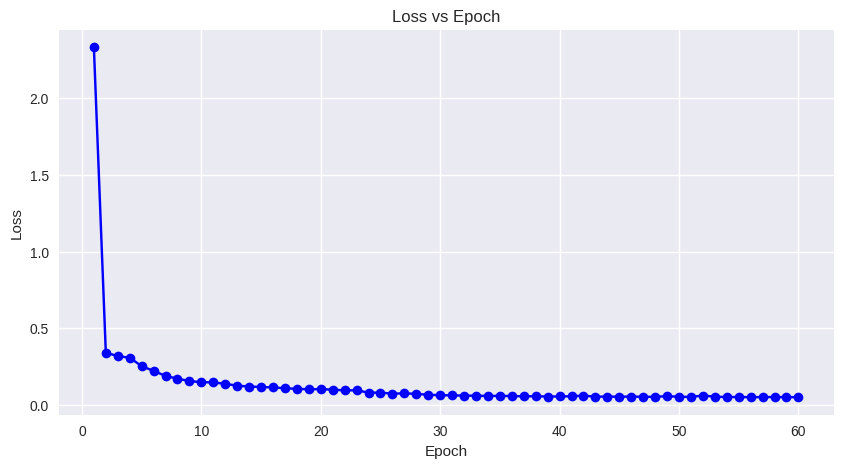

In [24]:
his = logger2.history
loss = [h["val_loss"] for h in his]
epochs = list(range(1, len(loss) + 1))

plt.figure(figsize=(10, 5))
plt.plot(epochs, loss, marker='o', linestyle='-', color='b')
plt.title("Loss vs Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [25]:
performance = pd.DataFrame([model.eval(test_L)])
performance

  0%|          | 0/12 [00:00<?, ?it/s]

,loss,accuracy,MSE,MAE
0,0.051098,0.745921,0.051599,0.161929


### Q2.3 HyperParameter Tuning

In [26]:
params_regression = [{
    'lr': 0.001,
    'batch_size': 128,
    'epoch': 20,
    'use_dropout': True,
    'kernel_size': 3,
    'padding': 1,
    'task': 'regression',
    'dropout_rate': 0.5
}, 
{
    'lr': 0.01,
    'batch_size': 64,
    'epoch': 30,
    'use_dropout': True,
    'kernel_size': 3,
    'padding': 1,
    'task': 'regression',
    'dropout_rate': 0.3
},
{
    'lr': 0.0005,
    'batch_size': 256,
    'epoch': 40,
    'use_dropout': True,
    'kernel_size': 3,
    'padding': 1,
    'task': 'regression',
    'dropout_rate': 0.4
},
{
    'lr': 0.002,
    'batch_size': 128,
    'epoch': 50,
    'use_dropout': True,
    'kernel_size': 3,
    'padding': 1,
    'task': 'regression',
    'dropout_rate': 0.25
},
{
    'lr': 0.005,
    'batch_size': 100,
    'epoch': 60,
    'use_dropout': True,
    'kernel_size': 3,
    'padding': 1,
    'task': 'regression',
    'dropout_rate': 0.35
}]


In [27]:
path = "/home/autrio/college-linx/SMAI/smai-m24-assignments-Autrio/data/external/double_mnist"


In [28]:
metrics.task = "regression"

In [29]:
evaluation_regression = []
logger3 = logger()
model.logger = logger3

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/710 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

Data Split into (4600, 2) test samples, (12600, 2) training samples and (3000, 2) Validation samples


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/710 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

Data Split into (4600, 2) test samples, (12600, 2) training samples and (3000, 2) Validation samples


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/710 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

Data Split into (4600, 2) test samples, (12600, 2) training samples and (3000, 2) Validation samples


Training:   0%|          | 0/20 [00:00<?, ?epoch/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[Epoch: 0] Train:[loss:0.031 acc:0.943] Val:[loss:0.042 acc:0.630]


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[Epoch: 1] Train:[loss:0.030 acc:0.946] Val:[loss:0.041 acc:0.645]


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[Epoch: 2] Train:[loss:0.029 acc:0.946] Val:[loss:0.041 acc:0.639]


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[Epoch: 3] Train:[loss:0.029 acc:0.946] Val:[loss:0.039 acc:0.650]


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[Epoch: 4] Train:[loss:0.028 acc:0.949] Val:[loss:0.039 acc:0.653]


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[Epoch: 5] Train:[loss:0.028 acc:0.949] Val:[loss:0.039 acc:0.649]


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[Epoch: 6] Train:[loss:0.027 acc:0.950] Val:[loss:0.041 acc:0.641]


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[Epoch: 7] Train:[loss:0.028 acc:0.949] Val:[loss:0.038 acc:0.657]


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[Epoch: 8] Train:[loss:0.026 acc:0.951] Val:[loss:0.038 acc:0.655]


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[Epoch: 9] Train:[loss:0.027 acc:0.951] Val:[loss:0.038 acc:0.652]


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[Epoch: 10] Train:[loss:0.026 acc:0.951] Val:[loss:0.037 acc:0.661]


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[Epoch: 11] Train:[loss:0.028 acc:0.949] Val:[loss:0.037 acc:0.660]


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[Epoch: 12] Train:[loss:0.026 acc:0.952] Val:[loss:0.037 acc:0.664]


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[Epoch: 13] Train:[loss:0.025 acc:0.954] Val:[loss:0.037 acc:0.664]


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[Epoch: 14] Train:[loss:0.025 acc:0.954] Val:[loss:0.036 acc:0.666]


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[Epoch: 15] Train:[loss:0.024 acc:0.954] Val:[loss:0.037 acc:0.657]


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[Epoch: 16] Train:[loss:0.024 acc:0.955] Val:[loss:0.037 acc:0.664]


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[Epoch: 17] Train:[loss:0.025 acc:0.954] Val:[loss:0.035 acc:0.670]


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[Epoch: 18] Train:[loss:0.024 acc:0.955] Val:[loss:0.037 acc:0.657]


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[Epoch: 19] Train:[loss:0.024 acc:0.956] Val:[loss:0.036 acc:0.665]


  0%|          | 0/24 [00:00<?, ?it/s]

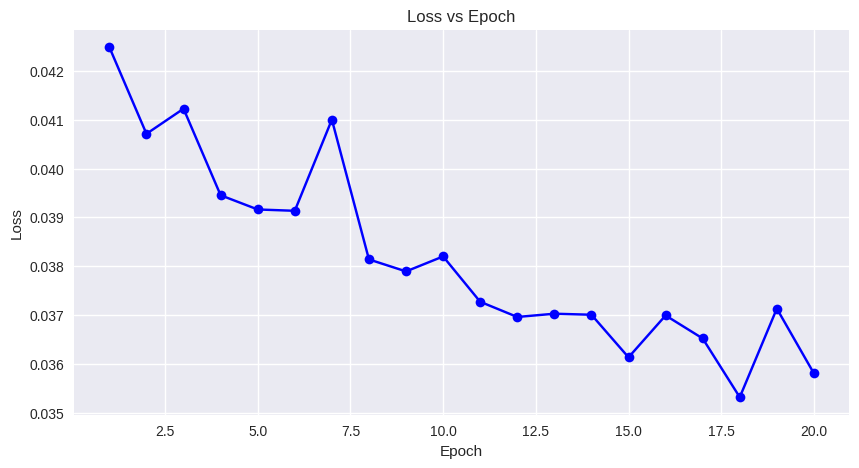

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/710 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

Data Split into (4600, 2) test samples, (12600, 2) training samples and (3000, 2) Validation samples


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/710 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

Data Split into (4600, 2) test samples, (12600, 2) training samples and (3000, 2) Validation samples


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/710 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

Data Split into (4600, 2) test samples, (12600, 2) training samples and (3000, 2) Validation samples


Training:   0%|          | 0/30 [00:00<?, ?epoch/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

[Epoch: 0] Train:[loss:0.024 acc:0.954] Val:[loss:0.036 acc:0.386]


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

[Epoch: 1] Train:[loss:0.025 acc:0.953] Val:[loss:0.038 acc:0.360]


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

[Epoch: 2] Train:[loss:0.024 acc:0.956] Val:[loss:0.034 acc:0.390]


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

[Epoch: 3] Train:[loss:0.024 acc:0.955] Val:[loss:0.034 acc:0.394]


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

[Epoch: 4] Train:[loss:0.023 acc:0.957] Val:[loss:0.035 acc:0.391]


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

[Epoch: 5] Train:[loss:0.024 acc:0.954] Val:[loss:0.037 acc:0.368]


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

[Epoch: 6] Train:[loss:0.023 acc:0.957] Val:[loss:0.036 acc:0.371]


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

[Epoch: 7] Train:[loss:0.022 acc:0.959] Val:[loss:0.033 acc:0.390]


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

[Epoch: 8] Train:[loss:0.022 acc:0.959] Val:[loss:0.035 acc:0.376]


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

[Epoch: 9] Train:[loss:0.022 acc:0.959] Val:[loss:0.033 acc:0.396]


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

[Epoch: 10] Train:[loss:0.022 acc:0.958] Val:[loss:0.033 acc:0.393]


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

[Epoch: 11] Train:[loss:0.021 acc:0.961] Val:[loss:0.032 acc:0.401]


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

[Epoch: 12] Train:[loss:0.022 acc:0.960] Val:[loss:0.032 acc:0.402]


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

[Epoch: 13] Train:[loss:0.021 acc:0.961] Val:[loss:0.032 acc:0.393]


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

[Epoch: 14] Train:[loss:0.021 acc:0.961] Val:[loss:0.032 acc:0.398]


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

[Epoch: 15] Train:[loss:0.021 acc:0.962] Val:[loss:0.036 acc:0.368]


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

[Epoch: 16] Train:[loss:0.021 acc:0.961] Val:[loss:0.031 acc:0.404]


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

[Epoch: 17] Train:[loss:0.020 acc:0.963] Val:[loss:0.031 acc:0.400]


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

[Epoch: 18] Train:[loss:0.020 acc:0.963] Val:[loss:0.030 acc:0.407]


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

[Epoch: 19] Train:[loss:0.020 acc:0.963] Val:[loss:0.033 acc:0.387]


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

[Epoch: 20] Train:[loss:0.020 acc:0.962] Val:[loss:0.033 acc:0.382]


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

[Epoch: 21] Train:[loss:0.019 acc:0.964] Val:[loss:0.033 acc:0.384]


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

[Epoch: 22] Train:[loss:0.020 acc:0.963] Val:[loss:0.030 acc:0.407]


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

[Epoch: 23] Train:[loss:0.019 acc:0.964] Val:[loss:0.033 acc:0.381]


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

[Epoch: 24] Train:[loss:0.019 acc:0.964] Val:[loss:0.030 acc:0.407]


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

[Epoch: 25] Train:[loss:0.019 acc:0.965] Val:[loss:0.030 acc:0.408]


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

[Epoch: 26] Train:[loss:0.019 acc:0.965] Val:[loss:0.030 acc:0.402]


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

[Epoch: 27] Train:[loss:0.018 acc:0.966] Val:[loss:0.029 acc:0.406]


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

[Epoch: 28] Train:[loss:0.019 acc:0.965] Val:[loss:0.031 acc:0.392]


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

[Epoch: 29] Train:[loss:0.018 acc:0.966] Val:[loss:0.029 acc:0.405]


  0%|          | 0/47 [00:00<?, ?it/s]

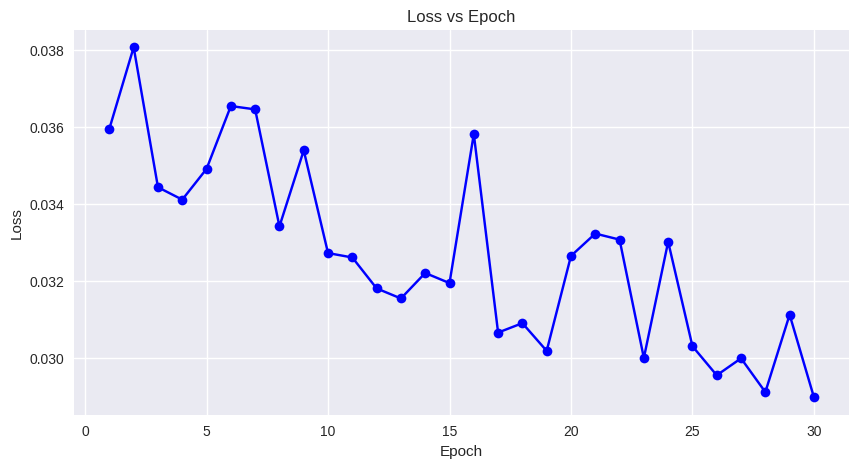

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/710 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

Data Split into (4600, 2) test samples, (12600, 2) training samples and (3000, 2) Validation samples


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/710 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

Data Split into (4600, 2) test samples, (12600, 2) training samples and (3000, 2) Validation samples


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/710 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

Data Split into (4600, 2) test samples, (12600, 2) training samples and (3000, 2) Validation samples


Training:   0%|          | 0/40 [00:00<?, ?epoch/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 0] Train:[loss:0.018 acc:0.968] Val:[loss:0.029 acc:0.792]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 1] Train:[loss:0.018 acc:0.968] Val:[loss:0.028 acc:0.794]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 2] Train:[loss:0.017 acc:0.968] Val:[loss:0.028 acc:0.795]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 3] Train:[loss:0.017 acc:0.968] Val:[loss:0.028 acc:0.795]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 4] Train:[loss:0.018 acc:0.968] Val:[loss:0.028 acc:0.791]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 5] Train:[loss:0.017 acc:0.968] Val:[loss:0.028 acc:0.794]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 6] Train:[loss:0.017 acc:0.969] Val:[loss:0.028 acc:0.794]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 7] Train:[loss:0.017 acc:0.968] Val:[loss:0.028 acc:0.792]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 8] Train:[loss:0.017 acc:0.968] Val:[loss:0.028 acc:0.792]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 9] Train:[loss:0.017 acc:0.969] Val:[loss:0.028 acc:0.794]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 10] Train:[loss:0.017 acc:0.969] Val:[loss:0.028 acc:0.793]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 11] Train:[loss:0.017 acc:0.969] Val:[loss:0.029 acc:0.780]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 12] Train:[loss:0.017 acc:0.969] Val:[loss:0.028 acc:0.792]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 13] Train:[loss:0.017 acc:0.968] Val:[loss:0.028 acc:0.797]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 14] Train:[loss:0.017 acc:0.969] Val:[loss:0.028 acc:0.787]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 15] Train:[loss:0.017 acc:0.969] Val:[loss:0.028 acc:0.798]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 16] Train:[loss:0.017 acc:0.969] Val:[loss:0.028 acc:0.790]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 17] Train:[loss:0.017 acc:0.969] Val:[loss:0.028 acc:0.796]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 18] Train:[loss:0.017 acc:0.970] Val:[loss:0.027 acc:0.798]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 19] Train:[loss:0.017 acc:0.969] Val:[loss:0.027 acc:0.799]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 20] Train:[loss:0.017 acc:0.970] Val:[loss:0.027 acc:0.795]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 21] Train:[loss:0.017 acc:0.969] Val:[loss:0.027 acc:0.798]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 22] Train:[loss:0.017 acc:0.970] Val:[loss:0.028 acc:0.792]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 23] Train:[loss:0.017 acc:0.970] Val:[loss:0.027 acc:0.800]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 24] Train:[loss:0.017 acc:0.969] Val:[loss:0.028 acc:0.795]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 25] Train:[loss:0.017 acc:0.968] Val:[loss:0.027 acc:0.797]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 26] Train:[loss:0.017 acc:0.969] Val:[loss:0.027 acc:0.794]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 27] Train:[loss:0.016 acc:0.970] Val:[loss:0.028 acc:0.786]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 28] Train:[loss:0.017 acc:0.970] Val:[loss:0.027 acc:0.798]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 29] Train:[loss:0.017 acc:0.970] Val:[loss:0.027 acc:0.795]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 30] Train:[loss:0.017 acc:0.969] Val:[loss:0.028 acc:0.787]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 31] Train:[loss:0.016 acc:0.970] Val:[loss:0.027 acc:0.799]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 32] Train:[loss:0.016 acc:0.970] Val:[loss:0.027 acc:0.800]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 33] Train:[loss:0.016 acc:0.970] Val:[loss:0.028 acc:0.788]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 34] Train:[loss:0.016 acc:0.970] Val:[loss:0.028 acc:0.788]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 35] Train:[loss:0.016 acc:0.970] Val:[loss:0.027 acc:0.797]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 36] Train:[loss:0.016 acc:0.971] Val:[loss:0.027 acc:0.800]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 37] Train:[loss:0.016 acc:0.970] Val:[loss:0.027 acc:0.800]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 38] Train:[loss:0.016 acc:0.971] Val:[loss:0.026 acc:0.800]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 39] Train:[loss:0.016 acc:0.971] Val:[loss:0.027 acc:0.800]


  0%|          | 0/12 [00:00<?, ?it/s]

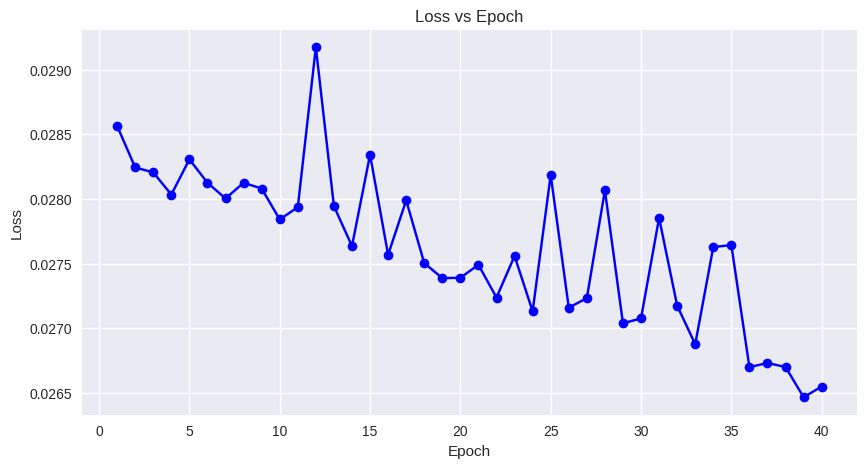

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/710 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

Data Split into (4600, 2) test samples, (12600, 2) training samples and (3000, 2) Validation samples


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/710 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

Data Split into (4600, 2) test samples, (12600, 2) training samples and (3000, 2) Validation samples


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/710 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

Data Split into (4600, 2) test samples, (12600, 2) training samples and (3000, 2) Validation samples


Training:   0%|          | 0/50 [00:00<?, ?epoch/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[Epoch: 0] Train:[loss:0.016 acc:0.970] Val:[loss:0.027 acc:0.698]


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[Epoch: 1] Train:[loss:0.017 acc:0.969] Val:[loss:0.027 acc:0.693]


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[Epoch: 2] Train:[loss:0.017 acc:0.969] Val:[loss:0.027 acc:0.695]


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[Epoch: 3] Train:[loss:0.016 acc:0.970] Val:[loss:0.028 acc:0.687]


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[Epoch: 4] Train:[loss:0.016 acc:0.970] Val:[loss:0.026 acc:0.700]


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[Epoch: 5] Train:[loss:0.016 acc:0.970] Val:[loss:0.027 acc:0.690]


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[Epoch: 6] Train:[loss:0.016 acc:0.971] Val:[loss:0.026 acc:0.696]


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[Epoch: 7] Train:[loss:0.016 acc:0.971] Val:[loss:0.027 acc:0.698]


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[Epoch: 8] Train:[loss:0.016 acc:0.970] Val:[loss:0.027 acc:0.695]


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[Epoch: 9] Train:[loss:0.016 acc:0.970] Val:[loss:0.031 acc:0.662]
Early stopping triggered after 10 epochs || best model accuracy : 0.6996534432906404


  0%|          | 0/24 [00:00<?, ?it/s]

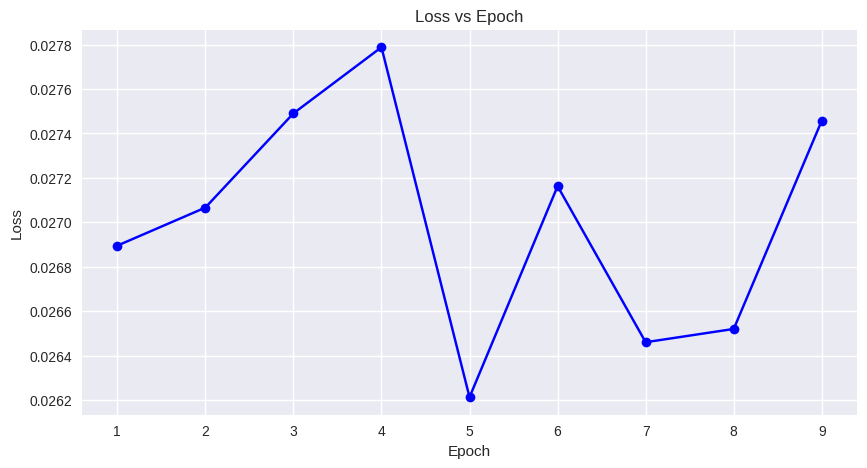

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/710 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

Data Split into (4600, 2) test samples, (12600, 2) training samples and (3000, 2) Validation samples


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/710 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

Data Split into (4600, 2) test samples, (12600, 2) training samples and (3000, 2) Validation samples


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/710 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

Data Split into (4600, 2) test samples, (12600, 2) training samples and (3000, 2) Validation samples


Training:   0%|          | 0/60 [00:00<?, ?epoch/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

[Epoch: 0] Train:[loss:0.017 acc:0.969] Val:[loss:0.029 acc:0.596]


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

[Epoch: 1] Train:[loss:0.016 acc:0.969] Val:[loss:0.027 acc:0.600]


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

[Epoch: 2] Train:[loss:0.016 acc:0.970] Val:[loss:0.026 acc:0.605]


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

[Epoch: 3] Train:[loss:0.016 acc:0.971] Val:[loss:0.026 acc:0.603]


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

[Epoch: 4] Train:[loss:0.016 acc:0.970] Val:[loss:0.027 acc:0.605]


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

[Epoch: 5] Train:[loss:0.016 acc:0.970] Val:[loss:0.028 acc:0.590]


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

[Epoch: 6] Train:[loss:0.016 acc:0.971] Val:[loss:0.027 acc:0.603]


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

[Epoch: 7] Train:[loss:0.016 acc:0.970] Val:[loss:0.028 acc:0.590]


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

[Epoch: 8] Train:[loss:0.016 acc:0.971] Val:[loss:0.027 acc:0.600]
Early stopping triggered after 9 epochs || best model accuracy : 0.6050854662079853


  0%|          | 0/30 [00:00<?, ?it/s]

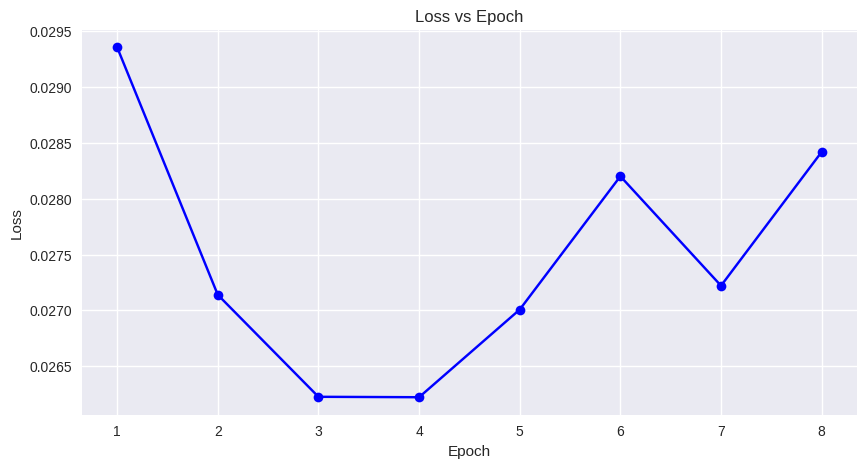

In [30]:
for param in params_regression: #!define new metrics and 
    model.params = param
    model.model.params = param
    model.metrics = metrics
    new_train_L,new_test_L,new_val_L = Loader(path,task=param['task'],batch_size = param['batch_size'])
    model.train_loader = new_train_L
    model.val_loader = new_val_L
    model.logger.history.clear()

    model.train()
    performance = model.eval(new_test_L)
    
    param["performance"] = performance
    evaluation_regression.append(param)
    his = logger3.history
    loss = [h["val_loss"] for h in his]
    epochs = list(range(1, len(loss) + 1))

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, loss, marker='o', linestyle='-', color='b')
    plt.title("Loss vs Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()
    

In [31]:
[x["performance"] for x in evaluation_regression]


[{'loss': 0.03171615145402029,
  'accuracy': 0.7380401074590469,
  'MSE': 0.0321321114897728,
  'MAE': 0.11557123810052872},
 {'loss': 0.02662586741288133,
  'accuracy': 0.4440039990638198,
  'MSE': 0.026662372052669525,
  'MAE': 0.10184907913208008},
 {'loss': 0.024283713855159778,
  'accuracy': 0.8503649367057342,
  'MSE': 0.024652322754263878,
  'MAE': 0.09892912954092026},
 {'loss': 0.023923562781419605,
  'accuracy': 0.7694217841027968,
  'MSE': 0.02424594573676586,
  'MAE': 0.09867478162050247},
 {'loss': 0.024362338023881117,
  'accuracy': 0.7108951297955337,
  'MSE': 0.024362334981560707,
  'MAE': 0.10065771639347076}]

In [32]:
params_single = [{
    'lr': 0.001,
    'batch_size': 64,
    'epoch': 20,
    'use_dropout': True,
    'kernel_size': 3,
    'padding': 1,
    'task': 'single',
    'dropout_rate': 0.5
}, 
{
    'lr': 0.01,
    'batch_size': 64,
    'epoch': 30,
    'use_dropout': True,
    'kernel_size': 3,
    'padding': 1,
    'task': 'single',
    'dropout_rate': 0.3
},
{
    'lr': 0.0005,
    'batch_size': 256,
    'epoch': 40,
    'use_dropout': True,
    'kernel_size': 3,
    'padding': 1,
    'task': 'single',
    'dropout_rate': 0.4
},
{
    'lr': 0.002,
    'batch_size': 32,
    'epoch': 50,
    'use_dropout': True,
    'kernel_size': 3,
    'padding': 1,
    'task': 'single',
    'dropout_rate': 0.25
},
{
    'lr': 0.005,
    'batch_size': 256,
    'epoch': 60,
    'use_dropout': True,
    'kernel_size': 3,
    'padding': 1,
    'task': 'single',
    'dropout_rate': 0.35
}]


In [33]:
path = "/home/autrio/college-linx/SMAI/smai-m24-assignments-Autrio/data/external/double_mnist"


In [34]:
evaluation_single = []

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/710 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

Data Split into (4600, 2) test samples, (12600, 2) training samples and (3000, 2) Validation samples


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/710 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

Data Split into (4600, 2) test samples, (12600, 2) training samples and (3000, 2) Validation samples


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/710 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

Data Split into (4600, 2) test samples, (12600, 2) training samples and (3000, 2) Validation samples


Training:   0%|          | 0/20 [00:00<?, ?epoch/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

[Epoch: 0] Train:[loss:0.947 acc:0.575] Val:[loss:0.871 acc:0.673]


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

[Epoch: 1] Train:[loss:0.811 acc:0.733] Val:[loss:0.823 acc:0.722]


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

[Epoch: 2] Train:[loss:0.784 acc:0.758] Val:[loss:0.741 acc:0.732]


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

[Epoch: 3] Train:[loss:0.753 acc:0.757] Val:[loss:0.586 acc:0.723]


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

[Epoch: 4] Train:[loss:0.730 acc:0.775] Val:[loss:0.571 acc:0.734]


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

[Epoch: 5] Train:[loss:0.729 acc:0.774] Val:[loss:0.562 acc:0.742]


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

[Epoch: 6] Train:[loss:0.718 acc:0.781] Val:[loss:0.559 acc:0.742]


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

[Epoch: 7] Train:[loss:0.721 acc:0.779] Val:[loss:0.649 acc:0.732]


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

[Epoch: 8] Train:[loss:0.726 acc:0.775] Val:[loss:0.614 acc:0.735]


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

[Epoch: 9] Train:[loss:0.721 acc:0.780] Val:[loss:0.570 acc:0.729]


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

[Epoch: 10] Train:[loss:0.720 acc:0.776] Val:[loss:0.561 acc:0.742]


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

[Epoch: 11] Train:[loss:0.720 acc:0.780] Val:[loss:0.573 acc:0.730]
Early stopping triggered after 12 epochs || best model accuracy : 0.7424311094996375


  0%|          | 0/47 [00:00<?, ?it/s]

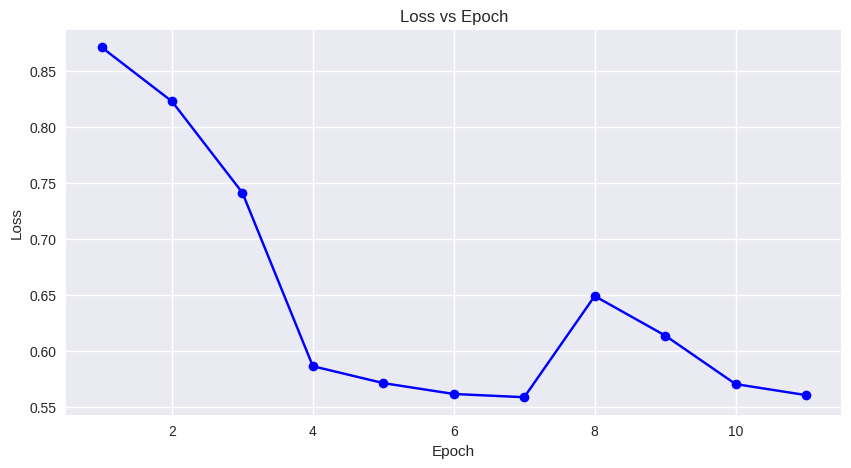

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/710 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

Data Split into (4600, 2) test samples, (12600, 2) training samples and (3000, 2) Validation samples


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/710 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

Data Split into (4600, 2) test samples, (12600, 2) training samples and (3000, 2) Validation samples


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/710 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

Data Split into (4600, 2) test samples, (12600, 2) training samples and (3000, 2) Validation samples


Training:   0%|          | 0/30 [00:00<?, ?epoch/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

[Epoch: 0] Train:[loss:0.956 acc:0.580] Val:[loss:0.882 acc:0.663]


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

[Epoch: 1] Train:[loss:0.898 acc:0.648] Val:[loss:0.891 acc:0.653]


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

[Epoch: 2] Train:[loss:1.061 acc:0.466] Val:[loss:1.303 acc:0.238]


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

[Epoch: 3] Train:[loss:1.197 acc:0.348] Val:[loss:1.307 acc:0.238]


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

[Epoch: 4] Train:[loss:1.198 acc:0.348] Val:[loss:1.303 acc:0.238]


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

[Epoch: 5] Train:[loss:1.200 acc:0.348] Val:[loss:1.307 acc:0.238]
Early stopping triggered after 6 epochs || best model accuracy : 0.6625611856417695


  0%|          | 0/47 [00:00<?, ?it/s]

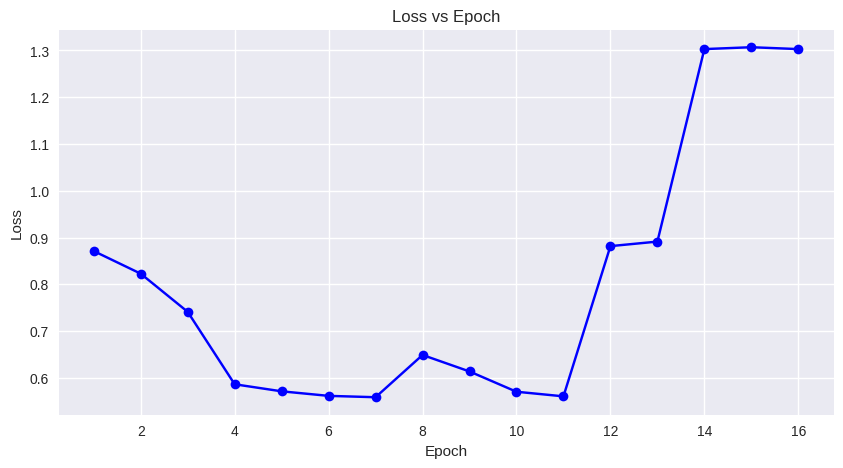

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/710 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

Data Split into (4600, 2) test samples, (12600, 2) training samples and (3000, 2) Validation samples


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/710 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

Data Split into (4600, 2) test samples, (12600, 2) training samples and (3000, 2) Validation samples


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/710 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

Data Split into (4600, 2) test samples, (12600, 2) training samples and (3000, 2) Validation samples


Training:   0%|          | 0/40 [00:00<?, ?epoch/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 0] Train:[loss:1.062 acc:0.430] Val:[loss:1.023 acc:0.513]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 1] Train:[loss:1.002 acc:0.519] Val:[loss:0.933 acc:0.621]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 2] Train:[loss:0.889 acc:0.659] Val:[loss:0.907 acc:0.635]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 3] Train:[loss:0.844 acc:0.707] Val:[loss:0.883 acc:0.663]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 4] Train:[loss:0.818 acc:0.732] Val:[loss:0.851 acc:0.699]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 5] Train:[loss:0.810 acc:0.738] Val:[loss:0.836 acc:0.714]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 6] Train:[loss:0.802 acc:0.747] Val:[loss:0.841 acc:0.708]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 7] Train:[loss:0.791 acc:0.761] Val:[loss:0.842 acc:0.708]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 8] Train:[loss:0.782 acc:0.768] Val:[loss:0.826 acc:0.724]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 9] Train:[loss:0.782 acc:0.770] Val:[loss:0.814 acc:0.737]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 10] Train:[loss:0.773 acc:0.777] Val:[loss:0.815 acc:0.735]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 11] Train:[loss:0.770 acc:0.779] Val:[loss:0.809 acc:0.742]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 12] Train:[loss:0.772 acc:0.778] Val:[loss:0.810 acc:0.740]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 13] Train:[loss:0.771 acc:0.780] Val:[loss:0.809 acc:0.741]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 14] Train:[loss:0.771 acc:0.780] Val:[loss:0.809 acc:0.742]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 15] Train:[loss:0.769 acc:0.780] Val:[loss:0.806 acc:0.742]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 16] Train:[loss:0.770 acc:0.781] Val:[loss:0.807 acc:0.743]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 17] Train:[loss:0.770 acc:0.780] Val:[loss:0.808 acc:0.742]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 18] Train:[loss:0.770 acc:0.781] Val:[loss:0.815 acc:0.735]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 19] Train:[loss:0.770 acc:0.780] Val:[loss:0.808 acc:0.742]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 20] Train:[loss:0.770 acc:0.781] Val:[loss:0.807 acc:0.743]
Early stopping triggered after 21 epochs || best model accuracy : 0.7428348214285714


  0%|          | 0/12 [00:00<?, ?it/s]

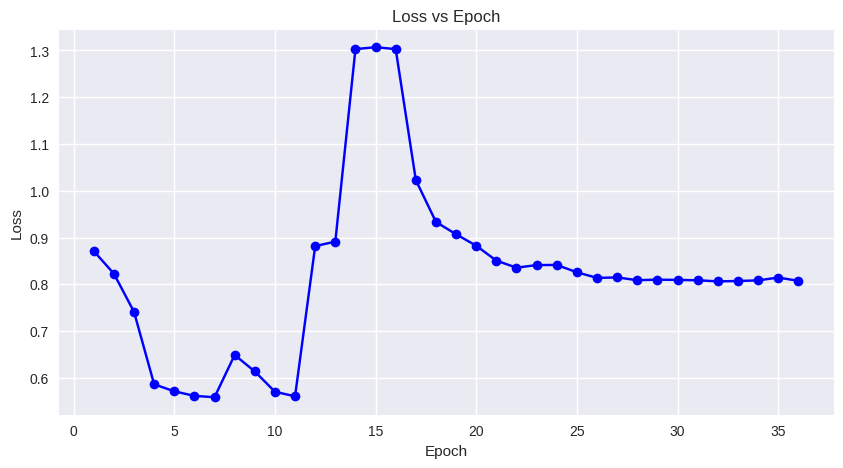

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/710 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

Data Split into (4600, 2) test samples, (12600, 2) training samples and (3000, 2) Validation samples


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/710 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

Data Split into (4600, 2) test samples, (12600, 2) training samples and (3000, 2) Validation samples


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/710 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

Data Split into (4600, 2) test samples, (12600, 2) training samples and (3000, 2) Validation samples


Training:   0%|          | 0/50 [00:00<?, ?epoch/s]

  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/394 [00:00<?, ?it/s]

[Epoch: 0] Train:[loss:0.885 acc:0.640] Val:[loss:0.823 acc:0.716]


  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/394 [00:00<?, ?it/s]

[Epoch: 1] Train:[loss:0.794 acc:0.746] Val:[loss:0.813 acc:0.726]


  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/394 [00:00<?, ?it/s]

[Epoch: 2] Train:[loss:0.793 acc:0.750] Val:[loss:0.822 acc:0.717]


  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/394 [00:00<?, ?it/s]

[Epoch: 3] Train:[loss:0.765 acc:0.771] Val:[loss:0.807 acc:0.732]


  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/394 [00:00<?, ?it/s]

[Epoch: 4] Train:[loss:0.774 acc:0.767] Val:[loss:0.854 acc:0.739]


  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/394 [00:00<?, ?it/s]

[Epoch: 5] Train:[loss:0.767 acc:0.777] Val:[loss:0.804 acc:0.735]


  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/394 [00:00<?, ?it/s]

[Epoch: 6] Train:[loss:0.781 acc:0.762] Val:[loss:0.846 acc:0.694]


  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/394 [00:00<?, ?it/s]

[Epoch: 7] Train:[loss:0.785 acc:0.753] Val:[loss:0.802 acc:0.737]


  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/394 [00:00<?, ?it/s]

[Epoch: 8] Train:[loss:0.773 acc:0.762] Val:[loss:0.807 acc:0.733]


  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/394 [00:00<?, ?it/s]

[Epoch: 9] Train:[loss:0.766 acc:0.772] Val:[loss:0.839 acc:0.700]


  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/394 [00:00<?, ?it/s]

[Epoch: 10] Train:[loss:0.773 acc:0.766] Val:[loss:0.815 acc:0.725]


  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/394 [00:00<?, ?it/s]

[Epoch: 11] Train:[loss:0.815 acc:0.726] Val:[loss:1.301 acc:0.238]


  0%|          | 0/144 [00:00<?, ?it/s]

  0%|          | 0/394 [00:00<?, ?it/s]

[Epoch: 12] Train:[loss:1.195 acc:0.348] Val:[loss:1.301 acc:0.238]
Early stopping triggered after 13 epochs || best model accuracy : 0.7387901861252114


  0%|          | 0/94 [00:00<?, ?it/s]

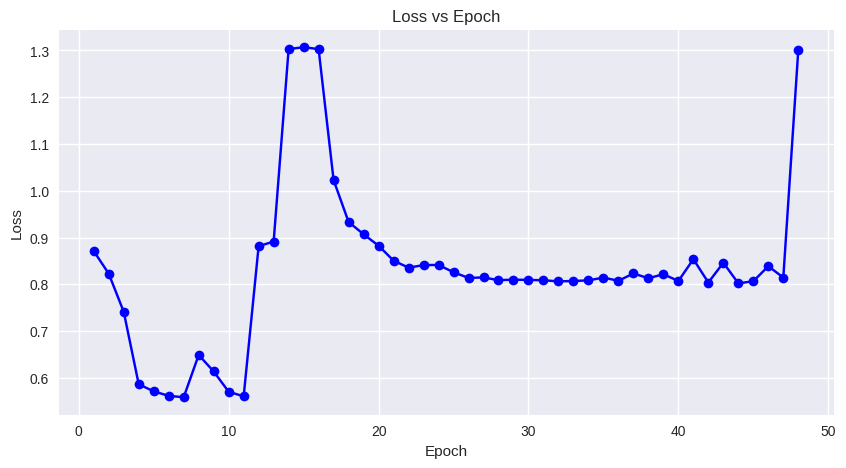

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/710 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

Data Split into (4600, 2) test samples, (12600, 2) training samples and (3000, 2) Validation samples


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/710 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

Data Split into (4600, 2) test samples, (12600, 2) training samples and (3000, 2) Validation samples


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/710 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

Data Split into (4600, 2) test samples, (12600, 2) training samples and (3000, 2) Validation samples


Training:   0%|          | 0/60 [00:00<?, ?epoch/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 0] Train:[loss:1.070 acc:0.417] Val:[loss:1.082 acc:0.409]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 1] Train:[loss:1.062 acc:0.434] Val:[loss:1.055 acc:0.513]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 2] Train:[loss:1.062 acc:0.435] Val:[loss:1.054 acc:0.513]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 3] Train:[loss:1.062 acc:0.435] Val:[loss:1.061 acc:0.513]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 4] Train:[loss:1.062 acc:0.435] Val:[loss:1.064 acc:0.513]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 5] Train:[loss:nan acc:0.222] Val:[loss:nan acc:0.000]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 6] Train:[loss:nan acc:0.000] Val:[loss:nan acc:0.000]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 7] Train:[loss:nan acc:0.000] Val:[loss:nan acc:0.000]
Early stopping triggered after 8 epochs || best model accuracy : 0.5128348214285715


  0%|          | 0/12 [00:00<?, ?it/s]

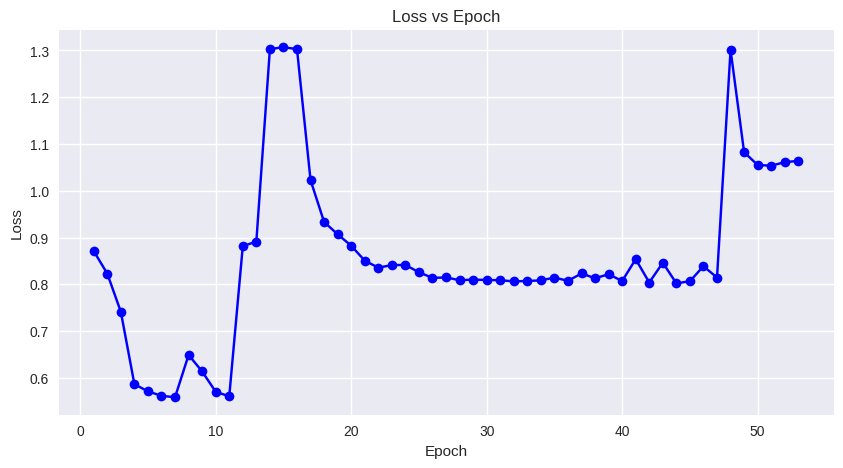

In [35]:
logger4 = logger()

for param in params_single: 
    new_train_L,new_test_L,new_val_L = Loader(path,task=param['task'],batch_size = param['batch_size'])
    net2 = cnn.net(params=param)
    single_class_net(net2)
    model2 = cnn.Model(net2)
    metrics2 = Metrics(task=param["task"])
    model2.set_attr(loss_fn=metrics2.loss_fn(),train_loader=new_train_L,val_loader=new_val_L,device=device,
                    metrics=metrics2,params=param,logger=logger4)
    
    model2.train()
    performance = model2.eval(new_test_L)
    
    param["performance"] = performance
    evaluation_single.append(param)
    his = logger4.history
    loss = [h["val_loss"] for h in his]
    epochs = list(range(1, len(loss) + 1))

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, loss, marker='o', linestyle='-', color='b')
    plt.title("Loss vs Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()

    


In [36]:
[x["performance"] for x in evaluation_single]

[{'loss': 0.5597536842873756,
  'accuracy': 0.7288183890577508,
  'hamming loss': 0.27,
  'f1 score': 0.4982295855918867},
 {'loss': 0.8708190309240463,
  'accuracy': 0.6756268996960486,
  'hamming loss': 0.3233333333333333,
  'f1 score': 0.5346554098071905},
 {'loss': 0.8165526042381922,
  'accuracy': 0.7317708333333334,
  'hamming loss': 0.26866666666666666,
  'f1 score': 0.5977407238552689},
 {'loss': 0.8097118025130414,
  'accuracy': 0.7293882978723404,
  'hamming loss': 0.26866666666666666,
  'f1 score': 0.5977407238552689},
 {'loss': 1.0528229922056198,
  'accuracy': 0.5385388360507246,
  'hamming loss': 0.4666666666666667,
  'f1 score': 0.23188405797101452}]

### Q2.3 - Q2.4 Selecting the best performing model parameters:

In [37]:
best_params_single = {'lr': 0.002,
    'batch_size': 128,
    'epoch': 50,
    'use_dropout': True,
    'kernel_size': 3,
    'padding': 1,
    'task': 'single',
    'dropout_rate': 0.25
    }
best_params_regression = {
    'lr': 0.002,
    'batch_size': 128,
    'epoch': 50,
    'use_dropout': True,
    'kernel_size': 3,
    'padding': 1,
    'task': 'regression',
    'dropout_rate': 0.25
}

In [38]:
BEST_net = cnn.net(best_params_single)
single_class_net(BEST_net)
BEST_model = cnn.Model(BEST_net)
BEST_metrics = Metrics(task='single')
BEST_model.set_attr(loss_fn=BEST_metrics.loss_fn(),train_loader=train_L,val_loader=val_L,
                    device=device,metrics=BEST_metrics,params=best_params_single,logger=None)

In [39]:
BEST_model.train()

Training:   0%|          | 0/50 [00:00<?, ?epoch/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 0] Train:[loss:1.021 acc:0.499] Val:[loss:0.953 acc:0.591]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 1] Train:[loss:0.897 acc:0.652] Val:[loss:0.899 acc:0.648]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 2] Train:[loss:0.861 acc:0.687] Val:[loss:0.852 acc:0.696]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 3] Train:[loss:0.876 acc:0.668] Val:[loss:0.853 acc:0.689]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 4] Train:[loss:0.806 acc:0.718] Val:[loss:0.651 acc:0.702]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 5] Train:[loss:0.767 acc:0.744] Val:[loss:0.611 acc:0.712]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 6] Train:[loss:0.742 acc:0.767] Val:[loss:0.614 acc:0.717]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 7] Train:[loss:0.738 acc:0.769] Val:[loss:0.576 acc:0.739]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 8] Train:[loss:0.725 acc:0.778] Val:[loss:0.566 acc:0.740]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 9] Train:[loss:0.730 acc:0.771] Val:[loss:0.577 acc:0.744]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 10] Train:[loss:0.723 acc:0.780] Val:[loss:0.577 acc:0.726]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 11] Train:[loss:0.733 acc:0.770] Val:[loss:0.571 acc:0.739]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 12] Train:[loss:0.724 acc:0.779] Val:[loss:0.569 acc:0.734]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 13] Train:[loss:0.728 acc:0.780] Val:[loss:0.563 acc:0.740]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 14] Train:[loss:0.726 acc:0.778] Val:[loss:0.581 acc:0.723]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 15] Train:[loss:0.731 acc:0.773] Val:[loss:0.574 acc:0.736]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 16] Train:[loss:0.729 acc:0.780] Val:[loss:0.560 acc:0.743]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 17] Train:[loss:0.724 acc:0.780] Val:[loss:0.560 acc:0.744]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 18] Train:[loss:0.728 acc:0.778] Val:[loss:0.567 acc:0.737]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 19] Train:[loss:0.727 acc:0.779] Val:[loss:0.564 acc:0.738]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 20] Train:[loss:0.724 acc:0.781] Val:[loss:0.562 acc:0.742]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 21] Train:[loss:0.725 acc:0.781] Val:[loss:0.562 acc:0.743]
Early stopping triggered after 22 epochs || best model accuracy : 0.7438504464285713



### Q2.4 Feature Maps Visualisation

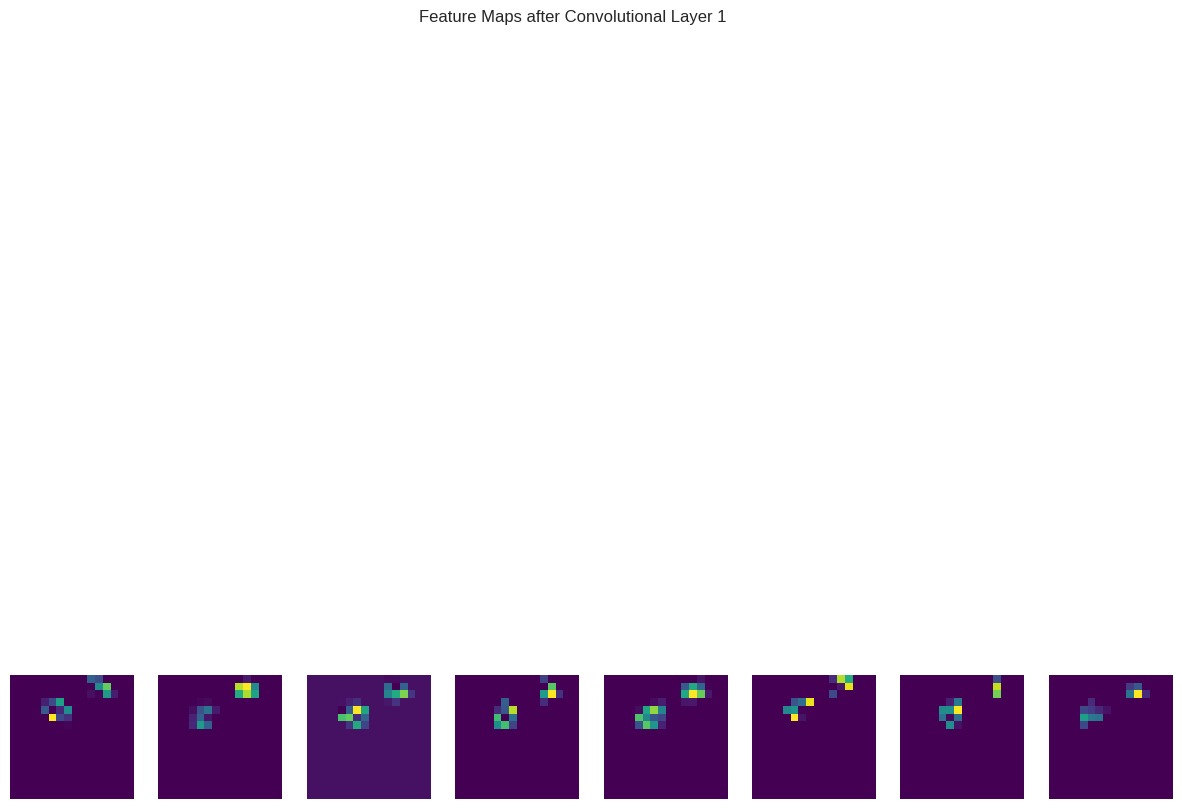

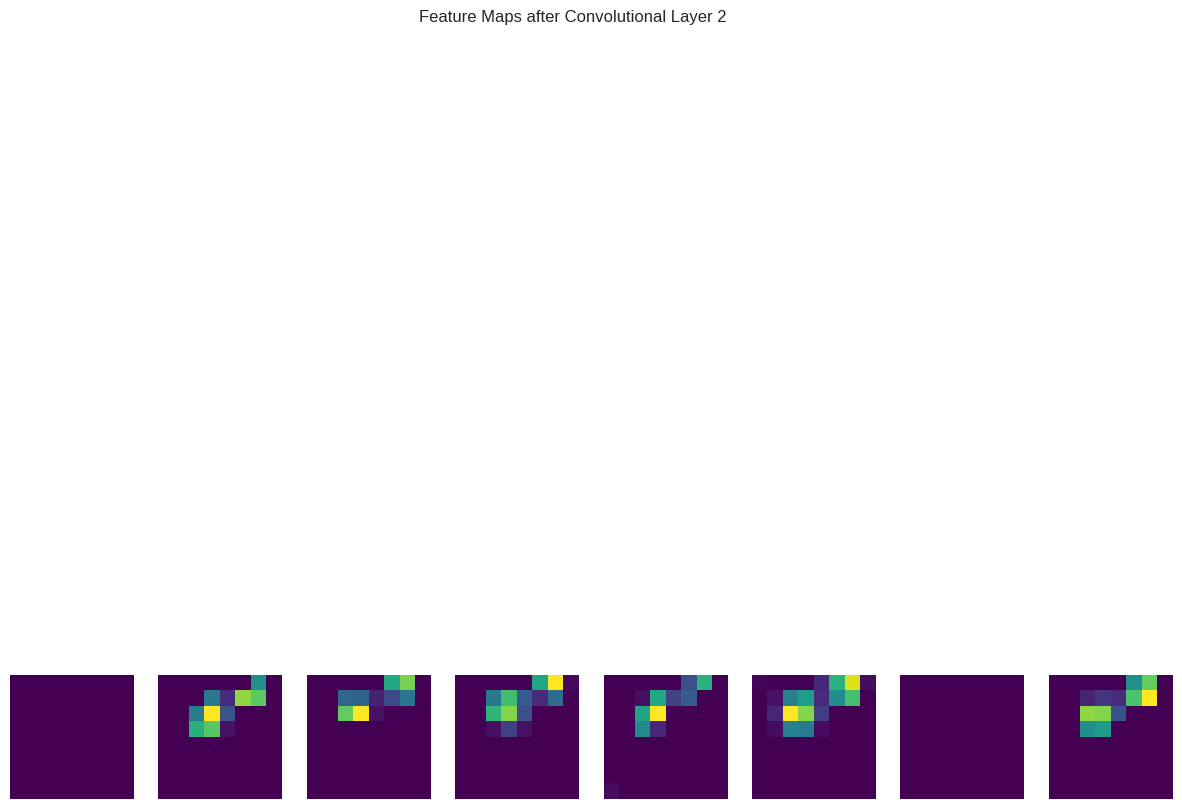

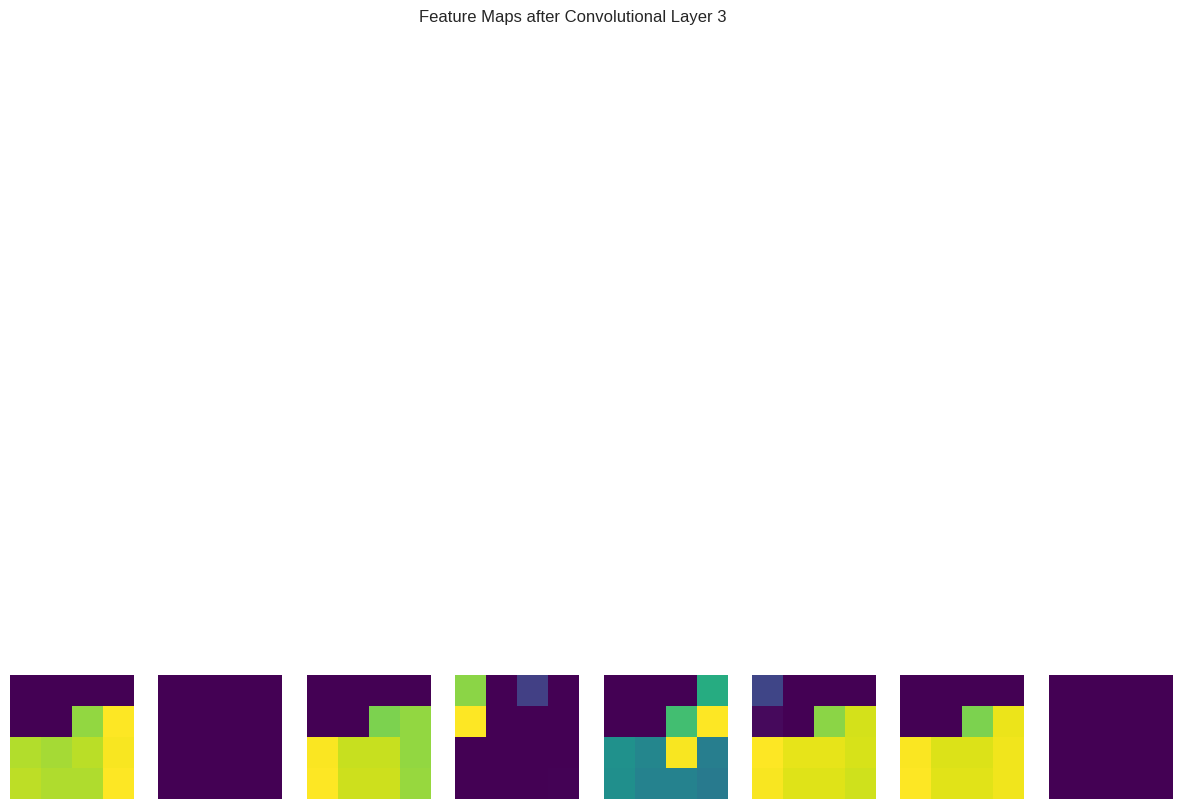

In [40]:
BEST_model.model.feature_map(sample_tensor.to(device))

---

# Q3 - CNN Multi-label Classification

### Q3.1 - Data Loading and Preprocessing

In [41]:
params = {
    'lr' : 1e-4,
    'batch_size': 256,
    'epoch': 50, 
    'use_dropout': True,
    'kernel_size': 3,
    'padding': 1,
    'task' : 'multi'
}

In [42]:
path = "/home/autrio/college-linx/SMAI/smai-m24-assignments-Autrio/data/external/double_mnist"
train_L,test_L,val_L = Loader(path,task=params['task'],batch_size = params['batch_size'])

single_batch = next(iter(train_L))
inputs, labels = single_batch

sample_tensor = inputs[0]
print(sample_tensor.shape)

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/710 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

Data Split into (4600, 2) test samples, (12600, 2) training samples and (3000, 2) Validation samples


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/710 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

Data Split into (4600, 2) test samples, (12600, 2) training samples and (3000, 2) Validation samples


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/710 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

Data Split into (4600, 2) test samples, (12600, 2) training samples and (3000, 2) Validation samples
torch.Size([1, 32, 32])


### Q3.2 Multi-label CNN Run

In [43]:
net = cnn.net(params)
#! 1 x 32 x 32
net.add(net.Convlayer(1,32))
#! 32 x 16 x 16
net.add(net.Convlayer(32,64))
net.add(net.drop())
#! 64 x 8 x 8
net.add(net.Convlayer(64,128))
#! 128 x 4 x 4
net.add(nn.Flatten())
net.add(net.drop())

net.add(nn.Linear(128*4*4,128*1*1))
net.add(nn.Linear(128,10))
net.add(nn.Sigmoid())

In [44]:
metrics = Metrics(task=params['task'])

model = cnn.Model(model=net)
model.set_attr(loss_fn=metrics.loss_fn(),train_loader=train_L,val_loader=val_L,
               device=device,params=params,metrics=metrics,logger=None)

In [45]:

model.train()

Training:   0%|          | 0/50 [00:00<?, ?epoch/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 0] Train:[loss:4.041 acc:0.565] Val:[loss:4.410 acc:0.539]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 1] Train:[loss:3.971 acc:0.577] Val:[loss:4.533 acc:0.485]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 2] Train:[loss:3.960 acc:0.581] Val:[loss:4.530 acc:0.498]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 3] Train:[loss:3.957 acc:0.601] Val:[loss:4.511 acc:0.485]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 4] Train:[loss:3.955 acc:0.560] Val:[loss:4.513 acc:0.531]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 5] Train:[loss:3.954 acc:0.583] Val:[loss:4.510 acc:0.507]
Early stopping triggered after 6 epochs || best model accuracy : 0.539181919642857


In [46]:
performance = pd.DataFrame([model.eval(test_L)])
performance

  0%|          | 0/12 [00:00<?, ?it/s]

,loss,accuracy,hamming loss,f1 score
0,4.472827,0.532405,0.47,0.105501


### Q3.3 HyperParameter Tuning

---


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/710 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

Data Split into (4600, 2) test samples, (12600, 2) training samples and (3000, 2) Validation samples


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/710 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

Data Split into (4600, 2) test samples, (12600, 2) training samples and (3000, 2) Validation samples


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/710 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

Data Split into (4600, 2) test samples, (12600, 2) training samples and (3000, 2) Validation samples


Training:   0%|          | 0/20 [00:00<?, ?epoch/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[Epoch: 0] Train:[loss:3.978 acc:0.634] Val:[loss:4.527 acc:0.585]


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[Epoch: 1] Train:[loss:3.933 acc:0.648] Val:[loss:4.520 acc:0.538]


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[Epoch: 2] Train:[loss:3.882 acc:0.622] Val:[loss:4.537 acc:0.532]


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[Epoch: 3] Train:[loss:3.859 acc:0.623] Val:[loss:4.554 acc:0.541]


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[Epoch: 4] Train:[loss:3.841 acc:0.628] Val:[loss:4.536 acc:0.499]


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[Epoch: 5] Train:[loss:3.828 acc:0.624] Val:[loss:4.508 acc:0.518]


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[Epoch: 6] Train:[loss:3.799 acc:0.644] Val:[loss:4.485 acc:0.535]


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[Epoch: 7] Train:[loss:3.757 acc:0.661] Val:[loss:4.472 acc:0.587]


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[Epoch: 8] Train:[loss:3.733 acc:0.666] Val:[loss:4.400 acc:0.578]


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[Epoch: 9] Train:[loss:3.687 acc:0.697] Val:[loss:4.373 acc:0.585]


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[Epoch: 10] Train:[loss:3.661 acc:0.706] Val:[loss:4.395 acc:0.610]


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[Epoch: 11] Train:[loss:3.642 acc:0.713] Val:[loss:4.376 acc:0.607]


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[Epoch: 12] Train:[loss:3.621 acc:0.723] Val:[loss:4.347 acc:0.609]


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[Epoch: 13] Train:[loss:3.605 acc:0.728] Val:[loss:4.332 acc:0.614]


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[Epoch: 14] Train:[loss:3.584 acc:0.737] Val:[loss:4.332 acc:0.610]


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[Epoch: 15] Train:[loss:3.569 acc:0.737] Val:[loss:4.327 acc:0.632]


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[Epoch: 16] Train:[loss:3.560 acc:0.746] Val:[loss:4.318 acc:0.640]


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[Epoch: 17] Train:[loss:3.540 acc:0.758] Val:[loss:4.296 acc:0.619]


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[Epoch: 18] Train:[loss:3.532 acc:0.756] Val:[loss:4.281 acc:0.619]


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[Epoch: 19] Train:[loss:3.532 acc:0.759] Val:[loss:4.279 acc:0.632]


  0%|          | 0/24 [00:00<?, ?it/s]

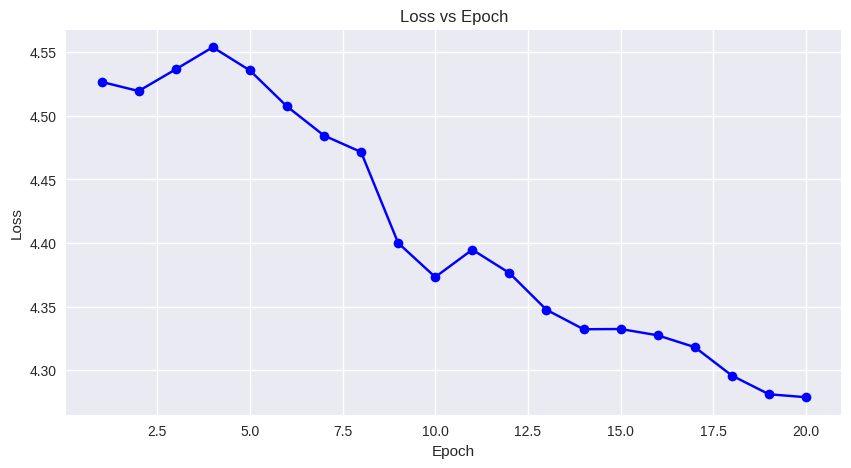

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/710 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

Data Split into (4600, 2) test samples, (12600, 2) training samples and (3000, 2) Validation samples


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/710 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

Data Split into (4600, 2) test samples, (12600, 2) training samples and (3000, 2) Validation samples


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/710 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

Data Split into (4600, 2) test samples, (12600, 2) training samples and (3000, 2) Validation samples


Training:   0%|          | 0/30 [00:00<?, ?epoch/s]

  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

[Epoch: 0] Train:[loss:3.952 acc:0.613] Val:[loss:4.528 acc:0.490]


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

[Epoch: 1] Train:[loss:3.892 acc:0.605] Val:[loss:4.535 acc:0.483]


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

[Epoch: 2] Train:[loss:3.879 acc:0.589] Val:[loss:4.520 acc:0.439]


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

[Epoch: 3] Train:[loss:3.849 acc:0.571] Val:[loss:4.518 acc:0.469]


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

[Epoch: 4] Train:[loss:3.849 acc:0.575] Val:[loss:4.504 acc:0.485]


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

[Epoch: 5] Train:[loss:3.837 acc:0.594] Val:[loss:4.523 acc:0.486]


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

[Epoch: 6] Train:[loss:3.820 acc:0.618] Val:[loss:4.520 acc:0.561]


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

[Epoch: 7] Train:[loss:3.792 acc:0.625] Val:[loss:4.454 acc:0.532]


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

[Epoch: 8] Train:[loss:3.773 acc:0.632] Val:[loss:4.438 acc:0.536]


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

[Epoch: 9] Train:[loss:3.854 acc:0.668] Val:[loss:4.452 acc:0.562]


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

[Epoch: 10] Train:[loss:3.834 acc:0.642] Val:[loss:4.419 acc:0.498]


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

[Epoch: 11] Train:[loss:3.826 acc:0.650] Val:[loss:4.457 acc:0.594]


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

[Epoch: 12] Train:[loss:3.801 acc:0.644] Val:[loss:4.477 acc:0.532]


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

[Epoch: 13] Train:[loss:3.794 acc:0.631] Val:[loss:4.465 acc:0.511]


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

[Epoch: 14] Train:[loss:3.818 acc:0.659] Val:[loss:4.392 acc:0.497]


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

[Epoch: 15] Train:[loss:3.803 acc:0.637] Val:[loss:4.465 acc:0.548]


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

[Epoch: 16] Train:[loss:3.797 acc:0.630] Val:[loss:4.471 acc:0.548]


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

[Epoch: 17] Train:[loss:3.794 acc:0.624] Val:[loss:4.468 acc:0.568]


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

[Epoch: 18] Train:[loss:3.792 acc:0.645] Val:[loss:4.408 acc:0.549]


  0%|          | 0/72 [00:00<?, ?it/s]

  0%|          | 0/197 [00:00<?, ?it/s]

[Epoch: 19] Train:[loss:3.774 acc:0.641] Val:[loss:4.433 acc:0.577]
Early stopping triggered after 20 epochs || best model accuracy : 0.594031000725163


  0%|          | 0/47 [00:00<?, ?it/s]

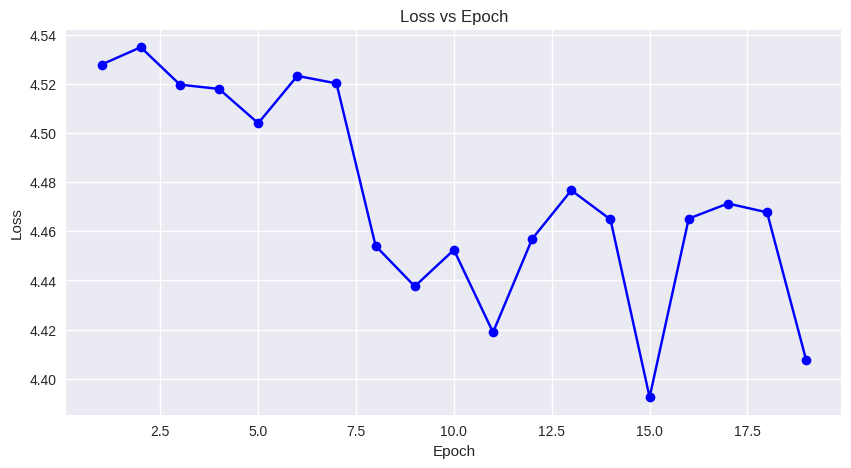

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/710 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

Data Split into (4600, 2) test samples, (12600, 2) training samples and (3000, 2) Validation samples


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/710 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

Data Split into (4600, 2) test samples, (12600, 2) training samples and (3000, 2) Validation samples


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/710 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

Data Split into (4600, 2) test samples, (12600, 2) training samples and (3000, 2) Validation samples


Training:   0%|          | 0/40 [00:00<?, ?epoch/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 0] Train:[loss:3.987 acc:0.590] Val:[loss:4.552 acc:0.545]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 1] Train:[loss:3.957 acc:0.632] Val:[loss:4.530 acc:0.485]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 2] Train:[loss:3.948 acc:0.603] Val:[loss:4.517 acc:0.586]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 3] Train:[loss:3.912 acc:0.651] Val:[loss:4.512 acc:0.553]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 4] Train:[loss:3.874 acc:0.637] Val:[loss:4.556 acc:0.530]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 5] Train:[loss:3.861 acc:0.628] Val:[loss:4.567 acc:0.532]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 6] Train:[loss:3.860 acc:0.629] Val:[loss:4.553 acc:0.530]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 7] Train:[loss:3.851 acc:0.613] Val:[loss:4.563 acc:0.527]


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

[Epoch: 8] Train:[loss:3.847 acc:0.623] Val:[loss:4.558 acc:0.516]
Early stopping triggered after 9 epochs || best model accuracy : 0.5861104910714284


  0%|          | 0/12 [00:00<?, ?it/s]

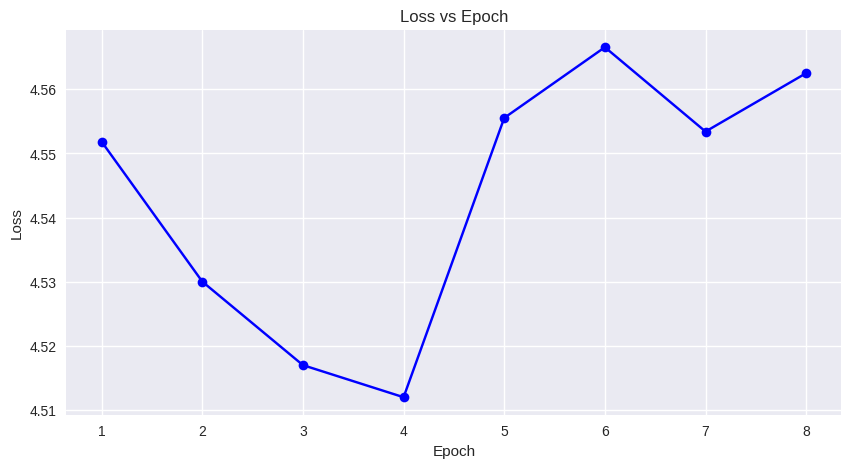

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/710 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

Data Split into (4600, 2) test samples, (12600, 2) training samples and (3000, 2) Validation samples


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/710 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

Data Split into (4600, 2) test samples, (12600, 2) training samples and (3000, 2) Validation samples


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/710 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

Data Split into (4600, 2) test samples, (12600, 2) training samples and (3000, 2) Validation samples


Training:   0%|          | 0/50 [00:00<?, ?epoch/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[Epoch: 0] Train:[loss:3.976 acc:0.570] Val:[loss:4.526 acc:0.487]


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[Epoch: 1] Train:[loss:3.930 acc:0.627] Val:[loss:4.529 acc:0.575]


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[Epoch: 2] Train:[loss:3.882 acc:0.643] Val:[loss:4.555 acc:0.577]


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[Epoch: 3] Train:[loss:3.869 acc:0.630] Val:[loss:4.551 acc:0.511]


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[Epoch: 4] Train:[loss:3.852 acc:0.624] Val:[loss:4.568 acc:0.554]


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[Epoch: 5] Train:[loss:3.837 acc:0.630] Val:[loss:4.524 acc:0.512]


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[Epoch: 6] Train:[loss:3.827 acc:0.636] Val:[loss:4.541 acc:0.564]


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[Epoch: 7] Train:[loss:3.808 acc:0.653] Val:[loss:4.527 acc:0.552]


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[Epoch: 8] Train:[loss:3.786 acc:0.647] Val:[loss:4.490 acc:0.549]


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[Epoch: 9] Train:[loss:3.764 acc:0.658] Val:[loss:4.473 acc:0.552]


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[Epoch: 10] Train:[loss:3.752 acc:0.663] Val:[loss:4.429 acc:0.558]


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[Epoch: 11] Train:[loss:3.721 acc:0.678] Val:[loss:4.422 acc:0.560]


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[Epoch: 12] Train:[loss:3.693 acc:0.685] Val:[loss:4.416 acc:0.610]


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[Epoch: 13] Train:[loss:3.673 acc:0.700] Val:[loss:4.409 acc:0.601]


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[Epoch: 14] Train:[loss:3.652 acc:0.714] Val:[loss:4.403 acc:0.609]


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[Epoch: 15] Train:[loss:3.639 acc:0.716] Val:[loss:4.354 acc:0.577]


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[Epoch: 16] Train:[loss:3.634 acc:0.726] Val:[loss:4.368 acc:0.620]


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[Epoch: 17] Train:[loss:3.626 acc:0.722] Val:[loss:4.379 acc:0.607]


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[Epoch: 18] Train:[loss:3.614 acc:0.722] Val:[loss:4.385 acc:0.632]


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[Epoch: 19] Train:[loss:3.602 acc:0.732] Val:[loss:4.361 acc:0.618]


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[Epoch: 20] Train:[loss:3.586 acc:0.739] Val:[loss:4.341 acc:0.628]


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[Epoch: 21] Train:[loss:3.573 acc:0.747] Val:[loss:4.310 acc:0.605]


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[Epoch: 22] Train:[loss:3.560 acc:0.745] Val:[loss:4.319 acc:0.625]


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[Epoch: 23] Train:[loss:3.550 acc:0.751] Val:[loss:4.312 acc:0.636]


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[Epoch: 24] Train:[loss:3.541 acc:0.757] Val:[loss:4.305 acc:0.655]


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[Epoch: 25] Train:[loss:3.520 acc:0.769] Val:[loss:4.286 acc:0.633]


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[Epoch: 26] Train:[loss:3.521 acc:0.768] Val:[loss:4.297 acc:0.676]


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[Epoch: 27] Train:[loss:3.494 acc:0.781] Val:[loss:4.255 acc:0.674]


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[Epoch: 28] Train:[loss:3.479 acc:0.787] Val:[loss:4.233 acc:0.684]


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[Epoch: 29] Train:[loss:3.468 acc:0.795] Val:[loss:4.258 acc:0.675]


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[Epoch: 30] Train:[loss:3.459 acc:0.797] Val:[loss:4.218 acc:0.688]


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[Epoch: 31] Train:[loss:3.438 acc:0.809] Val:[loss:4.199 acc:0.695]


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[Epoch: 32] Train:[loss:3.430 acc:0.812] Val:[loss:4.197 acc:0.698]


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[Epoch: 33] Train:[loss:3.411 acc:0.820] Val:[loss:4.199 acc:0.705]


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[Epoch: 34] Train:[loss:3.400 acc:0.826] Val:[loss:4.205 acc:0.709]


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[Epoch: 35] Train:[loss:3.397 acc:0.828] Val:[loss:4.147 acc:0.703]


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[Epoch: 36] Train:[loss:3.371 acc:0.833] Val:[loss:4.145 acc:0.717]


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[Epoch: 37] Train:[loss:3.371 acc:0.837] Val:[loss:4.120 acc:0.713]


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[Epoch: 38] Train:[loss:3.355 acc:0.842] Val:[loss:4.124 acc:0.725]


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[Epoch: 39] Train:[loss:3.350 acc:0.845] Val:[loss:4.124 acc:0.740]


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[Epoch: 40] Train:[loss:3.342 acc:0.849] Val:[loss:4.102 acc:0.720]


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[Epoch: 41] Train:[loss:3.333 acc:0.849] Val:[loss:4.100 acc:0.744]


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[Epoch: 42] Train:[loss:3.322 acc:0.858] Val:[loss:4.097 acc:0.740]


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[Epoch: 43] Train:[loss:3.309 acc:0.859] Val:[loss:4.080 acc:0.736]


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[Epoch: 44] Train:[loss:3.303 acc:0.862] Val:[loss:4.099 acc:0.741]


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[Epoch: 45] Train:[loss:3.297 acc:0.861] Val:[loss:4.068 acc:0.749]


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[Epoch: 46] Train:[loss:3.299 acc:0.863] Val:[loss:4.059 acc:0.752]


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[Epoch: 47] Train:[loss:3.297 acc:0.865] Val:[loss:4.051 acc:0.749]


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[Epoch: 48] Train:[loss:3.289 acc:0.864] Val:[loss:4.044 acc:0.750]


  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

[Epoch: 49] Train:[loss:3.273 acc:0.872] Val:[loss:4.017 acc:0.744]


  0%|          | 0/24 [00:00<?, ?it/s]

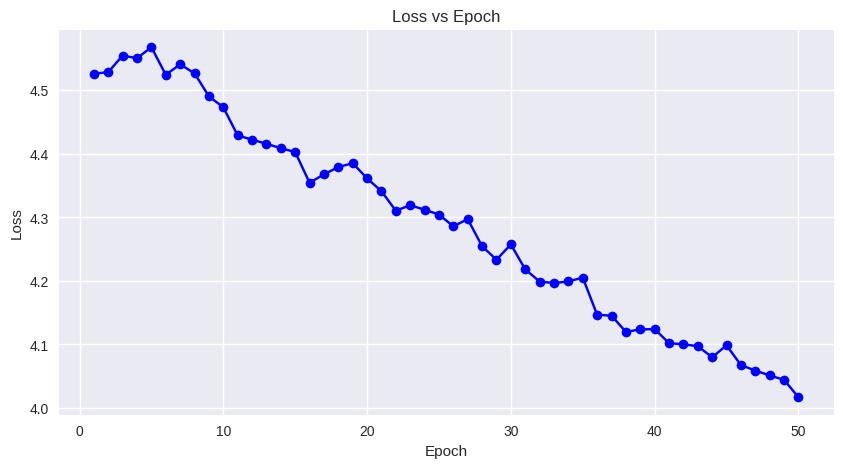

  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/710 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

Data Split into (4600, 2) test samples, (12600, 2) training samples and (3000, 2) Validation samples


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/710 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

Data Split into (4600, 2) test samples, (12600, 2) training samples and (3000, 2) Validation samples


  0%|          | 0/224 [00:00<?, ?it/s]

  0%|          | 0/710 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

Data Split into (4600, 2) test samples, (12600, 2) training samples and (3000, 2) Validation samples


Training:   0%|          | 0/60 [00:00<?, ?epoch/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

[Epoch: 0] Train:[loss:3.973 acc:0.604] Val:[loss:4.488 acc:0.559]


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

[Epoch: 1] Train:[loss:3.956 acc:0.609] Val:[loss:4.512 acc:0.608]


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

[Epoch: 2] Train:[loss:3.955 acc:0.640] Val:[loss:4.533 acc:0.546]


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

[Epoch: 3] Train:[loss:3.954 acc:0.621] Val:[loss:4.469 acc:0.546]


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

[Epoch: 4] Train:[loss:3.956 acc:0.628] Val:[loss:4.513 acc:0.549]


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

[Epoch: 5] Train:[loss:3.954 acc:0.623] Val:[loss:4.511 acc:0.608]


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

[Epoch: 6] Train:[loss:3.955 acc:0.647] Val:[loss:4.531 acc:0.546]


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

[Epoch: 7] Train:[loss:3.954 acc:0.647] Val:[loss:4.520 acc:0.546]


  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/126 [00:00<?, ?it/s]

[Epoch: 8] Train:[loss:3.953 acc:0.670] Val:[loss:4.527 acc:0.545]
Early stopping triggered after 9 epochs || best model accuracy : 0.6078174603174601


  0%|          | 0/30 [00:00<?, ?it/s]

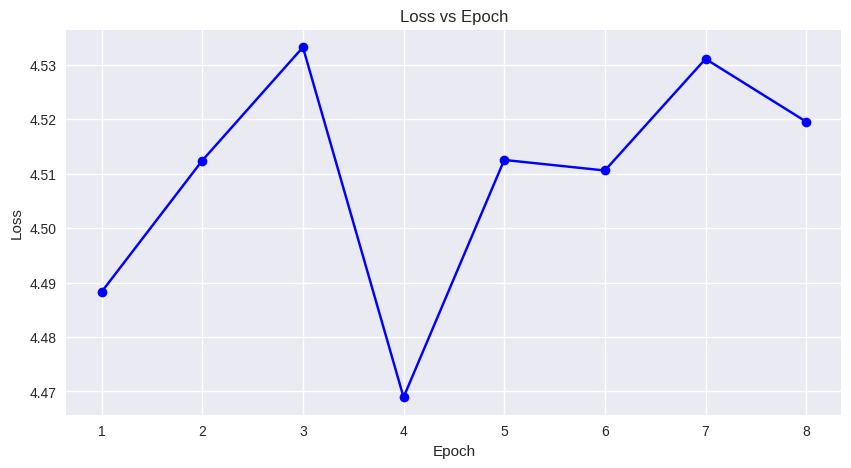

[]

In [48]:
params_multi = [{
    'lr': 0.001,
    'batch_size': 128,
    'epoch': 20,
    'use_dropout': True,
    'kernel_size': 3,
    'padding': 1,
    'task': 'multi',
    'dropout_rate': 0.5
}, 
{
    'lr': 0.01,
    'batch_size': 64,
    'epoch': 30,
    'use_dropout': True,
    'kernel_size': 3,
    'padding': 1,
    'task': 'multi',
    'dropout_rate': 0.3
},
{
    'lr': 0.0005,
    'batch_size': 256,
    'epoch': 40,
    'use_dropout': True,
    'kernel_size': 3,
    'padding': 1,
    'task': 'multi',
    'dropout_rate': 0.4
},    # Plotting Loss vs. Epoch

{
    'lr': 0.002,
    'batch_size': 128,
    'epoch': 50,
    'use_dropout': True,
    'kernel_size': 3,
    'padding': 1,
    'task': 'multi',
    'dropout_rate': 0.25
},
{
    'lr': 0.005,
    'batch_size': 100,
    'epoch': 60,
    'use_dropout': True,
    'kernel_size': 3,
    'padding': 1,
    'task': 'multi',
    'dropout_rate': 0.35
}]

path = "/home/autrio/college-linx/SMAI/smai-m24-assignments-Autrio/data/external/double_mnist"

metrics.task = "multi"

def multi_class_net(usr_net):
    usr_net.add(usr_net.Convlayer(1,32))
    usr_net.add(usr_net.Convlayer(32,64))
    usr_net.add(usr_net.drop())
    usr_net.add(usr_net.Convlayer(64,128))
    usr_net.add(nn.Flatten())
    usr_net.add(usr_net.drop())
    usr_net.add(nn.Linear(128*4*4,128*1*1))
    usr_net.add(nn.Linear(128,10))
    usr_net.add(nn.Sigmoid())

evaluation_multi = []

for param in params_multi: #!define new metrics and 
    new_train_L,new_test_L,new_val_L = Loader(path,task=param['task'],batch_size = param['batch_size'])
    net3 = cnn.net(params=param)
    multi_class_net(net3)
    model3 = cnn.Model(net3)
    logger5 = logger()
    metrics3 = Metrics(task=param["task"])
    model3.set_attr(loss_fn=metrics3.loss_fn(),train_loader=new_train_L,val_loader=new_val_L,device=device,
                    metrics=metrics3,params=param,logger=logger5)
    model3.train()
    performance = model3.eval(new_test_L)
    
    param["performance"] = performance
    evaluation_single.append(param)
    his = logger5.history
    loss = [h["val_loss"] for h in his]
    epochs = list(range(1, len(loss) + 1))

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, loss, marker='o', linestyle='-', color='b')
    plt.title("Loss vs Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()

[x["performance"] for x in evaluation_multi]






